In [14]:
import numpy as np
import xarray as xr
import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import griddata
%matplotlib inline

## Generate timestamps within specified date range

In [15]:
def generate_timelist(start, end, delta_seconds):
    # define start and end times
    end = parse(end)
    start = parse(start)
    # number of seconds we want between each time stamp
    delta_seconds = 3600
    # calculate the timedelta in seconds
    total_seconds = (end - start).total_seconds()

    # add timestamps to list
    timelist = []
    timestamp = start
    while (total_seconds >= 0):
        timelist.append(timestamp)
        timestamp = timestamp +  datetime.timedelta(seconds=delta_seconds)
        total_seconds -= delta_seconds
    return timelist

In [16]:
generate_timelist('1 Jan 2017 00:30:00', '3 Jan 2017 23:30:00', 3600)[0:5] # taking a look at some of the list

[datetime.datetime(2017, 1, 1, 0, 30),
 datetime.datetime(2017, 1, 1, 1, 30),
 datetime.datetime(2017, 1, 1, 2, 30),
 datetime.datetime(2017, 1, 1, 3, 30),
 datetime.datetime(2017, 1, 1, 4, 30)]

## Generate constant field for 2D field

In [17]:
# mask for MOHID grid
mask = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02').tmaskutil.isel(time=0).values[1:897,1:397].T
def constant_field(fillvalue, mask=mask):
    # make an array using mask
    condlist = [mask==0, mask ==1]
    choicelist = [0, fillvalue]
    return np.select(condlist, choicelist)

## Create 3D field

In [18]:
#3D mask truncated and transposed at needed by MOHID
mask_3D = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DMeshMaskV17-02').tmask.isel(time=0).values[...,1:897, 1:397]
mask_3D = np.transpose(mask_3D, [0,2,1])

In [19]:
def constant_field3D(depth_list, fillvalue_list, mask_3D=mask_3D):
    """Generate constant 3D fields for MOHID
    
    :arg depth_list: list of depth indices
    :type list: :py:class:'list' 
    
    :arg fillvalue_list: list of fillvalues to apply at each depth index
    :type list: :py:class:'list'
    
    :arg mask_3D: 3D mask used to create constant fields. Shape (40,396,896).
    :type ndarray: :py:class:'ndarray' 
    """
    output_arr = np.zeros([40,396,896])
    for i in depth_list:
        output_arr[i] = constant_field(fillvalue_list[i], mask_3D[i])
    # flip depth dimension for MOHID
    return np.flip(output_arr, axis = 0)

## Currents

In [20]:
def create_currents_const(datelist, current_u, current_v, filename, compression_level = 1):
    # create hdf5 file and create tree structure
    f = h5py.File(filename, 'w')
    times = f.create_group('Time')
    velocity_u = f.create_group('/Results/velocity U')
    velocity_v = f.create_group('/Results/velocity V')

    # make list of time arrays
    datearrays = []
    for date in datelist:
        datearrays.append(
            np.array([date.year,date.month, date.day, date.hour, date.minute, date.second]).astype('float64')
            )

    # write time values to hdf5
    for i, datearray in enumerate(datearrays):
        child_name = 'Time_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
        dset = times.create_dataset(
            child_name,
            shape = (6,),
            data = datearray,
            chunks = (6,),
            compression = 'gzip',
            compression_opts = compression_level
            )
        metadata = {
            'Maximum' : np.array(datearrays[i][0]),
            'Minimum' : np.array([-0.]),
            'Units' : b'YYYY/MM/DD HH:MM:SS'
            } 
        dset.attrs.update(metadata)
        
        # U velocities
        child_name = 'velocity U_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
        dset = velocity_u.create_dataset(
            child_name,
            shape = (40, 396, 896),
            data = current_u,
            chunks = (40, 396, 896),
            compression = 'gzip',
            compression_opts = compression_level
            )
        metadata = {
            'FillValue' : np.array([0.]),
            'Maximum' : np.array([5.]),
            'Minimum' : np.array([-5.]),
            'Units' : b'm/s'
            }
        dset.attrs.update(metadata)
        
        # V velocities
        child_name = 'velocity V_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
        dset = velocity_v.create_dataset(
            child_name,
            shape = (40, 396, 896),
            data = current_v,
            chunks = (40, 396, 896),
            compression = 'gzip',
            compression_opts = compression_level
            )
        metadata = {
            'FillValue' : np.array([0.]),
            'Maximum' : np.array([5.]),
            'Minimum' : np.array([-5.]),
            'Units' : b'm/s'
            }
        dset.attrs.update(metadata)
    f.close()

## SSH

In [21]:
def create_ssh_const(datelist, ssh, filename, compression_level = 1):
    # create hdf5 file and tree structure
    f = h5py.File(filename, 'w')
    times = f.create_group('Time')
    water_level = f.create_group('/Results/water level')
        
    # make list of time arrays
    datearrays = []
    for date in datelist:
        datearrays.append(
            np.array([date.year,date.month, date.day, date.hour, date.minute, date.second]).astype('float64')
            )

    # write time values to hdf5
    for i, datearray in enumerate(datearrays):
        child_name = 'Time_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
        dset = times.create_dataset(
            child_name,
            shape = (6,),
            data = datearray,
            chunks = (6,),
            compression = 'gzip',
            compression_opts = compression_level
            )
        metadata = {
            'Maximum' : np.array(datearrays[i][0]),
            'Minimum' : np.array([-0.]),
            'Units' : b'YYYY/MM/DD HH:MM:SS'
            } 
        dset.attrs.update(metadata)

    # write  water level values to hdf5
        child_name = 'water level_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
        dset = water_level.create_dataset(
            child_name,
            shape = (396, 896),
            data = ssh,
            chunks = (396, 896),
            compression = 'gzip',
            compression_opts = compression_level
            )
        metadata = {
            'FillValue' : np.array([0.]),
            'Maximum' : np.array([5.]),
            'Minimum' : np.array([-5.]),
            'Units' : b'm'
            }
        dset.attrs.update(metadata)


    f.close()

## Winds

In [22]:
def create_winds_hdf5(datelist, u_wind, v_wind, filename, compression_level = 1):
    # create hdf5 file and create tree structure
    f = h5py.File(filename, 'w')
    times = f.create_group('Time')
    windu = f.create_group('/Results/wind velocity X')
    windv = f.create_group('/Results/wind velocity Y')
        
    # make list of time arrays
    datearrays = []
    for date in datelist:
        datearrays.append(
            np.array([date.year,date.month, date.day, date.hour, date.minute, date.second]).astype('float64')
            )

    # write time values to hdf5
    for i, datearray in enumerate(datearrays):
        child_name = 'Time_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
        dset = times.create_dataset(
            child_name,
            shape = (6,),
            data = datearray,
            chunks = (6,),
            compression = 'gzip',
            compression_opts = compression_level
            )
        metadata = {
            'Maximum' : np.array([float(datearrays[i][0])]),
            'Minimum' : np.array([-0.]),
            'Units' : b'YYYY/MM/DD HH:MM:SS'
            } 
        dset.attrs.update(metadata)

    # write X wind velocities to hdf5
        child_name = 'wind velocity X_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
        dset = windu.create_dataset(
            child_name,
            shape  = (396, 896),
            data = wind_u,
            chunks = (396, 896),
            compression = 'gzip',
            compression_opts = compression_level
            )
        metadata = {
            'FillValue' : np.array([0.]),
            'Maximum' : np.array([100.]),
            'Minimum' : np.array([-100.]),
            'Units' : b'm/s'
            }
        dset.attrs.update(metadata)

    # write Y wind velocities to hdf5
        child_name = 'wind velocity Y_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
        dset = windv.create_dataset(
            child_name,
            shape = (396, 896),
            data = wind_v,
            chunks = (396, 896),
            compression = 'gzip',
            compression_opts = compression_level
            )
        metadata = {
            'FillValue' : np.array([0.]),
            'Maximum' : np.array([100.]),
            'Minimum' : np.array([-100.]),
            'Units' : b'm/s'
            }
        dset.attrs.update(metadata)
    f.close()

## Waves

In [23]:
def create_ww3_hdf5(datelist, mean_wave_period, significant_wave_height, whitecap_coverage, filename, compression_level = 1):

    # create hdf5 file and create tree structure
    f = h5py.File(filename, 'w')
    times = f.create_group('Time')
    mwp = f.create_group('/Results/mean wave period')
    swh = f.create_group('/Results/significant wave height')
    wc  = f.create_group('/Results/whitecap coverage')
    
   
    # make list of time arrays
    datearrays = []
    for date in datelist:
        datearrays.append(
            np.array([date.year, date.month, date.day, date.hour, date.minute, date.second]).astype('float64')
            )

    # write time values to hdf5
    for i, datearray in enumerate(datearrays):
        child_name = 'Time_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
        dset = times.create_dataset(
            child_name,
            shape = (6,),
            data = datearray,
            chunks = (6,),
            #compression = 'gzip',
            #compression_opts = compression_level
            )
        metadata = {
            'Maximum' : np.array([float(datearray[0])]),
            'Minimum' : np.array([-0.]),
            'Units' : b'YYYY/MM/DD HH:MM:SS'
            } 
        dset.attrs.update(metadata)

    # write mean wave period to hdf5
        child_name = 'mean wave period_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
        dset = mwp.create_dataset(
            child_name,
            shape = (396, 896),
            data = mean_wave_period,
            chunks = (396, 896),
            #compression = 'gzip',
            #compression_opts = compression_level
            )
        metadata = {
            'FillValue' : np.array([0.]),
            'Maximum' : np.array([100000.]),
            'Minimum' : np.array([0.]),
            'Units' : b's'
            }
        dset.attrs.update(metadata)

    # write significant wave height to hdf5
        child_name = 'significant wave height_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
        dset = swh.create_dataset(
            child_name,
            shape = (396, 896),
            data = significant_wave_height,
            chunks = (396, 896),
            #compression = 'gzip',
            #compression_opts = compression_level
            )
        metadata = {
            'FillValue' : np.array([0.]),
            'Maximum' : np.array([100.]),
            'Minimum' : np.array([-100.]),
            'Units' : b'm'
            }
        dset.attrs.update(metadata)

    # write whitecap coverage to hdf5
        child_name = 'whitecap coverage_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
        dset = wc.create_dataset(
            child_name,
            shape = (396, 896),
            data = whitecap_coverage,
            chunks = (396, 896),
            #compression = 'gzip',
            #compression_opts = compression_level
            )
        metadata = {
            'FillValue' : np.array([0.]),
            'Maximum' : np.array([1.]),
            'Minimum' : np.array([0.]),
            'Units' : b'1'
            }
        dset.attrs.update(metadata)

    f.close()

## Example Usage

In [27]:
datelist = generate_timelist('1 Jan 2017 00:30:00', '7 Jan 2017 23:30:00', 3600)

#### ssh = 0

In [28]:
ssh_0 = constant_field(0) ## flat ssh of 0 metres

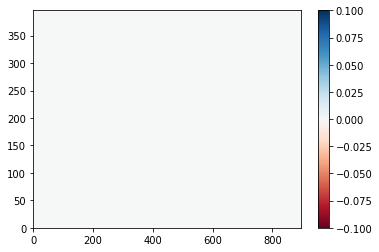

In [26]:
plt.pcolormesh(ssh_0,cmap = 'RdBu')
plt.colorbar()

In [31]:
create_ssh_const(datelist, ssh_0, '/ocean/abhudia/MEOPAR/analysis-ashutosh/data/ssh/ssh_0.hdf5')

### ssh = 2

In [32]:
ssh_2 = constant_field(2)

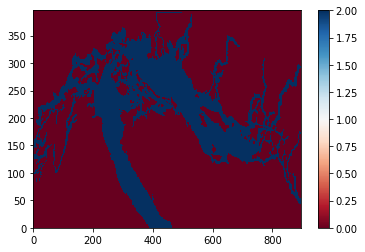

In [33]:
plt.pcolormesh(ssh_2,cmap = 'RdBu')
plt.colorbar()

In [34]:
create_ssh_const(datelist, ssh_2, '/ocean/abhudia/MEOPAR/analysis-ashutosh/data/ssh/ssh_2.hdf5')

### ssh = -2

In [35]:
ssh_neg2 = constant_field(-2)

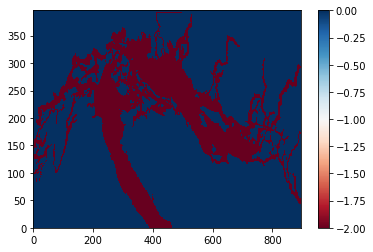

In [36]:
plt.pcolormesh(ssh_neg2,cmap = 'RdBu')
plt.colorbar()

In [37]:
create_ssh_const(datelist, ssh_neg2, '/ocean/abhudia/MEOPAR/analysis-ashutosh/data/ssh/ssh_neg2.hdf5')

### currents (u = -0.5 m/s ( 0 m/s) in upper 2 m (below 2 m), v = 0 m/s (0.5 m/s) in upper 2 m (below 2 m))

In [33]:
depth_list = [i for i in range(40)]
depth_fillvalue_u = [0,0]
for i in range(38):
    depth_fillvalue_u.append(-0.5)
depth_fillvalue_v = [0,0]
for i in range(38):
    depth_fillvalue_v.append(0.5)

current_u = constant_field3D(depth_list, depth_fillvalue_u)
current_v = constant_field3D(depth_list, depth_fillvalue_v)

In [38]:
create_currents_const(datelist, current_u, current_v, 'MIDOSS/currents_example_01.hdf5')

### u = 0.5 m/s, v = 0 m/s at all depths

In [39]:
depth_list = [i for i in range(40)]
depth_fillvalue_u = [0.5 for i in range(40)]
depth_fillvalue_v = [0 for i in range(40)]

current_u = constant_field3D(depth_list, depth_fillvalue_u)
current_v = constant_field3D(depth_list, depth_fillvalue_v)

In [40]:
create_currents_const(datelist, current_u, current_v, 'MIDOSS/currents_example_02.hdf5')

### SSH=0; waves = 0; winds = 0; u = -0.5 m/s ( 0 m/s) in upper 2 m (below 2 m), v = 0 m/s (0.5 m/s) in upper 2 m (below 2 m), i.e. east above 2m, and north below

In [42]:
wind_mask = np.ones([396, 896])
wind_u = constant_field(0)
wind_v = constant_field(0)
create_winds_hdf5(datelist, wind_u, wind_v, 'MIDOSS/zerowinds.hdf5')

In [14]:
depth_list = [i for i in range(40)]
depth_fillvalue_u = [-0.5,-0.5]
for i in range(38):
    depth_fillvalue_u.append(0)
depth_fillvalue_v = [0,0]
for i in range(38):
    depth_fillvalue_v.append(0.5)
mask_3Du = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DMeshMaskV17-02').umask.isel(time=0).values[...,1:897, 1:397]
mask_3Du = np.transpose(mask_3Du, [0,2,1])
mask_3Dv = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DMeshMaskV17-02').vmask.isel(time=0).values[...,1:897, 1:397]
mask_3Dv = np.transpose(mask_3Dv, [0,2,1])
current_u = constant_field3D(depth_list, depth_fillvalue_u, mask_3Du)
current_v = constant_field3D(depth_list, depth_fillvalue_v, mask_3Dv)

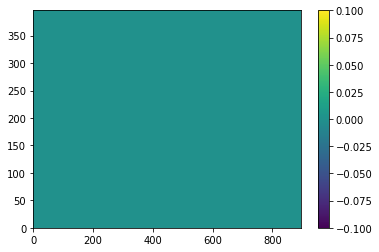

In [45]:
plt.pcolormesh(current_u[37])
plt.colorbar()

In [ ]:
# plt.pcolormesh(current_v[37])
plt.colorbar()

In [16]:
create_currents_const(datelist, current_u, current_v, '/ocean/abhudia/MEOPAR/analysis-ashutosh/data/constant_currents/currents_west_above2_north_below2.hdf5')

## Constant waves

In [49]:
# waves set to constant from actual file
wavefile = xr.open_dataset('/opp/wwatch3/nowcast/01dec17/SoG_ww3_fields_20171201_20171201.nc')

In [50]:
whitecap = wavefile.wcc.values[0]
mean_wave_period = wavefile.t02.values[0]
sig_wave_height = wavefile.hs.values[0]

NEMO_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02')
lat_lon_mesh = np.meshgrid(wavefile.MAPSTA.latitude.values, wavefile.MAPSTA.longitude.values)    
points = np.array([lat_lon_mesh[0].T.ravel(), lat_lon_mesh[1].T.ravel()-360]).T
# NEMO lat lon grids tuple
xi = (NEMO_grid.latitude.values, NEMO_grid.longitude.values)
# create an interpolated array of the 1st slice so you can stack it onto the rest
whitecap = griddata(points, whitecap.ravel(), xi, method='linear')[1:897, 1:397].T
mean_wave_period = griddata(points, mean_wave_period.ravel(), xi, method='linear')[1:897, 1:397].T
sig_wave_height = griddata(points, sig_wave_height.ravel(), xi, method='linear')[1:897, 1:397].T

In [51]:
create_ww3_hdf5(datelist, mean_wave_period, sig_wave_height, whitecap, '/ocean/abhudia/MEOPAR/analysis-ashutosh/data/constant_waves/constant_waves.hdf5')

### u = 0.5 m/s, v = 0 m/s at all depths 

In [13]:
depth_list = [i for i in range(40)]
depth_fillvalue_u = []
for i in range(40):
    depth_fillvalue_u.append(0.5)
depth_fillvalue_v = []
for i in range(40):
    depth_fillvalue_v.append(0)
mask_3Du = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DMeshMaskV17-02').umask.isel(time=0).values[...,1:897, 1:397]
mask_3Du = np.transpose(mask_3Du, [0,2,1])
mask_3Dv = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DMeshMaskV17-02').vmask.isel(time=0).values[...,1:897, 1:397]
mask_3Dv = np.transpose(mask_3Dv, [0,2,1])
current_u = constant_field3D(depth_list, depth_fillvalue_u, mask_3Du)
current_v = constant_field3D(depth_list, depth_fillvalue_v, mask_3Dv)

create_currents_const(datelist, current_u, current_v, 'MIDOSS/currents_u0-5_v0.hdf5')

Constant wind (u = 5 m/s, v = 0 m/s)

In [47]:
wind_mask = np.ones([396, 896])
wind_u = constant_field(5)
wind_v = constant_field(0)
create_winds_hdf5(datelist, wind_u, wind_v, '/ocean/abhudia/MEOPAR/analysis-ashutosh/data/winds_5u_0v.hdf5')

In [13]:
wind_mask = np.ones([396, 896])
wind_u = constant_field(0)
wind_v = constant_field(0)
create_winds_hdf5(datelist, wind_u, wind_v, '/ocean/abhudia/MEOPAR/analysis-ashutosh/data/zerowinds.hdf5')

In [52]:
datelist[0], datelist[-1]

(datetime.datetime(2017, 1, 1, 0, 30), datetime.datetime(2017, 1, 7, 23, 30))